In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wrangle as acq
import seaborn as sns
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from pydataset import data
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = data('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
df = df.dropna()
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


Create a column named price_per_person. This should be the total bill divided by the party size.

In [4]:
df['price_per_person'] = (df['total_bill'] + df['tip'] / df['size'])
df['sex'] = df['sex'].replace({'Male': '0', 'Female': '1',})
df['smoker'] = df['smoker'].replace({'Yes': '1', 'No': '0'})
df['day'] = df['day'].replace({'Sun': '1', 'Mon': '2', 'Tue': '3', 'Wed': '4', 'Thur': '5', 'Fri': '6', 'Sat': '7'})
df['time'] = df['time'].replace({'Lunch': '1', 'Dinner': '2'})



In [5]:
#df = acq.prep_tips(df) prep won't give me dummies

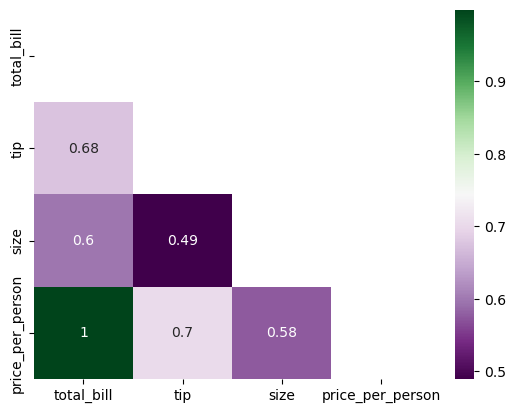

In [6]:
sns.heatmap(df.corr(), cmap='PRGn', annot=True,
           mask=np.triu(df.corr()))
plt.show()

In [7]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,1,0,1,2,2,17.495000
2,10.34,1.66,0,0,1,2,3,10.893333
3,21.01,3.50,0,0,1,2,3,22.176667
4,23.68,3.31,0,0,1,2,2,25.335000
5,24.59,3.61,1,0,1,2,4,25.492500


Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

most import features I think would be total bill, price per person, and party size

In [8]:
X, Y = acq.split_tips_data(df)

# splitting data into train, validate, and test
X_train, X_validate, X_test, y_train, y_validate, y_test = acq.train_validate_test_split(X, Y)


X_train = pd.DataFrame(X_train)
X_validate = pd.DataFrame(X_validate)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)


    X_train -> (136, 7)'
    X_validate -> (59, 7)'
    X_test -> (49, 7)


In [9]:
X_train.head()

,total_bill,sex,smoker,day,time,size,price_per_person
19,16.97,1,0,1,2,3,18.136667
173,7.25,0,1,1,2,2,9.825000
119,12.43,1,0,5,1,2,13.330000
29,21.70,0,0,7,2,2,23.850000
238,32.83,0,1,7,2,2,33.415000


In [10]:
#in order to view f scores inot a df to view

#pd.DataFrame(dict(p_value=kbest.pvalues_, f_score=kbest.scores_),
  #          index=X_train.columns)

### forgot to scale data

In [11]:
kbest = SelectKBest(f_regression, k=2)
kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x133ca9430>)

In [12]:
kbest.scores_

array([115.9849094 ,   1.15479204,   0.34490862,   1.57901026,
         1.79864746,  61.25908863, 134.39489158])

In [13]:
kbest.pvalues_

array([7.18647033e-20, 2.84479443e-01, 5.57997755e-01, 2.11089443e-01,
       1.82144884e-01, 1.34164190e-12, 5.92640967e-22])

In [14]:
kbest.feature_names_in_

array(['total_bill', 'sex', 'smoker', 'day', 'time', 'size',
       'price_per_person'], dtype=object)

In [15]:
kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                index = X_train.columns)

In [16]:
kbest_results

,p,f
total_bill,7.186470e-20,115.984909
sex,2.844794e-01,1.154792
smoker,5.579978e-01,0.344909
day,2.110894e-01,1.579010
time,1.821449e-01,1.798647
size,1.341642e-12,61.259089
price_per_person,5.926410e-22,134.394892


1. Price per person, 2. total_bill

In [17]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [18]:
#forgot to scale

rfe.ranking_

array([1, 6, 3, 5, 4, 2, 1])

In [19]:
pd.DataFrame(
{'rfe_ranking':rfe.ranking_},
index=X_train.columns)

,rfe_ranking
total_bill,1
sex,6
smoker,3
day,5
time,4
size,2
price_per_person,1


1. total bill and, 2. price person

Kbest bases it's ranking, at least, in part on p-value, isolating features against target.
While rfe bases its ranking after weighing all features against target.

In [20]:
def select_kbest(X_train, y_train, k):
    selector = SelectKBest(score_func = f_regression, k=2)
    selector.fit(X_train, y_train)
   # selector.feature_names_in_
    #print(selector.feature_names_in_)
    selected_features = X_train.columns[selector.get_support()]
    return selected_features

selected_features = select_kbest(X_train, y_train, k=2)
print(selected_features)

Index(['total_bill', 'price_per_person'], dtype='object')


In [21]:
X_train.head()

,total_bill,sex,smoker,day,time,size,price_per_person
19,16.97,1,0,1,2,3,18.136667
173,7.25,0,1,1,2,2,9.825000
119,12.43,1,0,5,1,2,13.330000
29,21.70,0,0,7,2,2,23.850000
238,32.83,0,1,7,2,2,33.415000


In [22]:
def rfe(X_train, y_train, n_features_to_select):
    model = LinearRegression()
    selector = RFE(model, n_features_to_select=2)
    #selector = RFE(n_features_to_select=2)
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]
    return selected_features

selected_features = rfe(X_train, y_train, n_features_to_select = 2)
print(selected_features)

Index(['total_bill', 'price_per_person'], dtype='object')


In [23]:
df = data('swiss')
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [24]:
df = df.dropna()
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [25]:
X, Y = acq.split_swiss_data(df)

# splitting data into train, validate, and test
X_train, X_validate, X_test, y_train, y_validate, y_test = acq.train_validate_test_split(X, Y)


X_train = pd.DataFrame(X_train)
X_validate = pd.DataFrame(X_validate)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)


    X_train -> (25, 5)'
    X_validate -> (12, 5)'
    X_test -> (10, 5)


In [26]:
kbest = SelectKBest(f_regression, k=2)
kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x133ca9430>)